In [68]:
!nvidia-smi

Tue Aug 10 16:18:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |  15847MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
!pip install transformers==3.2
!pip install tensorflow-addons

In [70]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from tensorflow.keras.models import clone_model

from tqdm import tqdm

# from keras import optimizers
from transformers import *
# from transformers import BertTokenizer, TFBertModel,PreTrainedTokenizerFast, TFBartModel
# from kobart_transformers import get_kobart_tokenizer, get_kobart_model

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences #tensorflow 전처리 모듈1
from tensorflow.keras.preprocessing.text import Tokenizer #tensorflow 전처리 모듈2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline 

In [71]:
import logging
import os
import unicodedata
from shutil import copyfile
 
from transformers import PreTrainedTokenizer
 
 
logger = logging.getLogger(__name__)
 
VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}
 
PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}
 
PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}
 
PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}
 
SPIECE_UNDERLINE = u'▁'
 
 
class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
 
    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )
 
        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)
 
        self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens
 
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
 
        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt
 
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)
 
    @property
    def vocab_size(self):
        return len(self.idx2token)
 
    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state
 
    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)
 
    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')
 
        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()
 
        return outputs
 
    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)
 
        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)
 
        return new_pieces
 
    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])
 
    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]
 
    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string
 
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep
 
    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """
 
        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))
 
        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]
 
    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]
 
    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return
 
        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])
 
        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)
 
        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
 
        return out_vocab_model, out_vocab_txt

In [127]:
PATH = '/content/drive/MyDrive/gh/dacon/techclf/DATA'
train_df = pd.read_csv(PATH + '/drop_train.csv')
test_df = pd.read_csv(PATH + '/drop_test.csv')

In [128]:
# down sampling

In [129]:
# cnt = 0
# for idx, i in enumerate(range(len(train_df))):
#     if train_df.label[i] == 0:
#         if cnt > 2000:
#             train_df.drop([i], inplace = True)
#         cnt +=1

In [130]:
for idx, i in tqdm(enumerate(range(len(train_df)))):
    if train_df.label[i] == 0:
        if idx % 2 != 0:
            train_df.drop([i], inplace = True)

174304it [13:57, 208.02it/s]


In [131]:
train = train_df
test = test_df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


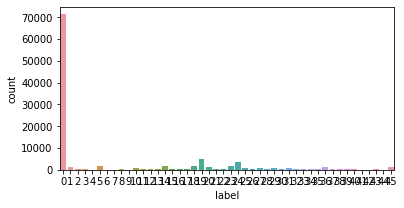

In [132]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train['label'])

In [133]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [134]:
model_name = 'monologg/kobert'
SEED_NUM = 977
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 128
NUM_EPOCHS = 30
VALID_SPLIT = 0.2
MAX_LEN = 36
NUM_CLASS = 46
K_SPLIT = 3

In [135]:
def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        
        text = sent,
        add_special_tokens = True, # True : 토큰 시작점에 [CLS] 토큰과 토큰의 마지막에 [SEP]토큰을 붙임
        max_length = MAX_LEN, # MAX_LEN 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행 ; MAX_LEN보다 길면 truncate
        pad_to_max_length = True, # True : MAX_LEN의 길이에 미치지 못하는 문장에 padding을 적용 **padding : 길이를 일괄적으로 맞춰주는 것
                                                     # 각 데이터의 길이가 다를경우 모델에 적용할 수 없음 그렇기에 padding진행
                                         
        return_attention_mask = True, # True : BERT에 필요한 입력값 중 attention_mask를 생성
        truncation = True 
        # encoded_plus 과정 중 token_type으로 문장이 1개면 0, 문장이 2개면 0과 1로 구분
    )


    input_id = encoded_dict['input_ids'] # BERT 입력값 중 하나인 input_ids
    attention_mask = encoded_dict['attention_mask'] # attention_mask ; 단순히 padding과 non-padding을 구분
    token_type_id = encoded_dict['token_type_ids'] # 두개의 문장 구분용


    return input_id, attention_mask, token_type_id # 각각의 BERT 입력값들을 encoded_dict를 한 결과를 return

In [136]:
print(tokenizer.all_special_tokens) # BERT special tokens
print(tokenizer.all_special_ids)  # BERT special tokens의 index

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[0, 3, 1, 2, 4]


In [137]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(train["c_text"], train["label"])): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
102948it [00:25, 4039.74it/s]


In [138]:
INPUT_id = train_news_input_ids[30]
ATTENTION_mask = train_news_attention_masks[30]
TOKEN_TYPE_id = train_news_type_ids[30]

print(INPUT_id)
print(ATTENTION_mask)
print(TOKEN_TYPE_id)
print(tokenizer.decode(INPUT_id))

[   2 1509 7348 7431 2906 3060 6441 5947 7014 2714 5563 1595 7088 3566
 3969 6312 5575    3    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 농촌진흥청 수출 심비디움 생산기간 단축을 위한 재배기술[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [139]:
class TFBertClassifier(tf.keras.Model):                                                           
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)                                                                                   
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(
            num_class,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
            name="classifier")


    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): 
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(
    model_name=model_name,
    dir_path='bert_ckpt',
    num_class=NUM_CLASS)



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [140]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=5.0e-5, total_steps = 2344*4, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric])

In [141]:
es_callback = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.0001,
    patience=5,
    baseline=0.4)

##
DATA_OUT_PATH = PATH + '/data_out'
##

checkpoint_path = DATA_OUT_PATH + '/best_modeling.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
    )


/content/drive/MyDrive/gh/dacon/techclf/DATA/data_out -- Folder already exists 



In [142]:
history = cls_model.fit(
    train_news_inputs,
    train_data_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = VALID_SPLIT,
    callbacks=[es_callback, cp_callback]
    )

Epoch 1/30
644/644 [==============================] - 462s 616ms/step - loss: 1.7832 - accuracy: 0.6154 - val_loss: 0.9754 - val_accuracy: 0.7579

Epoch 00001: val_loss improved from inf to 0.97542, saving model to /content/drive/MyDrive/gh/dacon/techclf/DATA/data_out/best_modeling.ckpt
Epoch 2/30
644/644 [==============================] - 397s 616ms/step - loss: 0.7877 - accuracy: 0.7827 - val_loss: 0.6564 - val_accuracy: 0.8127

Epoch 00002: val_loss improved from 0.97542 to 0.65637, saving model to /content/drive/MyDrive/gh/dacon/techclf/DATA/data_out/best_modeling.ckpt
Epoch 3/30
644/644 [==============================] - 396s 615ms/step - loss: 0.5684 - accuracy: 0.8299 - val_loss: 0.5491 - val_accuracy: 0.8345

Epoch 00003: val_loss improved from 0.65637 to 0.54909, saving model to /content/drive/MyDrive/gh/dacon/techclf/DATA/data_out/best_modeling.ckpt
Epoch 4/30
644/644 [==============================] - 395s 614ms/step - loss: 0.4484 - accuracy: 0.8625 - val_loss: 0.5330 - val

In [143]:
cls_model.summary()

Model: "tf_bert_classifier_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model_8 (TFBertModel multiple                  92186880  
_________________________________________________________________
dropout_341 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  35374     
Total params: 92,222,254
Trainable params: 92,222,254
Non-trainable params: 0
_________________________________________________________________


In [144]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for test_sent in test["c_text"]: 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_news_input_ids = np.array(input_ids, dtype=int)
test_news_attention_masks = np.array(attention_masks, dtype=int)
test_news_type_ids = np.array(token_type_ids, dtype=int)

test_news_inputs = (test_news_input_ids, test_news_attention_masks, test_news_type_ids)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [145]:
# model.load_weights(checkpoint_filepath)
cls_model_1 = TFBertClassifier(
    model_name=model_name,
    dir_path='bert_ckpt',
    num_class=NUM_CLASS
    )

cls_model_1.load_weights(os.path.join(DATA_OUT_PATH,'best_modeling.ckpt')) 

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [146]:
predictions = cls_model_1.predict(test_news_inputs)

In [147]:
submission = pd.read_csv(PATH + '/sample_submission.csv')

In [148]:
submission

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
...,...,...
43571,217875,0
43572,217876,0
43573,217877,0
43574,217878,0


In [149]:
pred = np.argmax(predictions, axis = 1)

In [150]:
submission.label = pred
submission.sample(3)

,index,label
21514,195818,0
21918,196222,0
43099,217403,37


In [151]:
submission.to_csv(PATH + '/submission/kobert_half2.csv',index = False)